In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
import io
!pip install squarify
import squarify
%matplotlib inline
sns.set_style('whitegrid')

In [5]:
data = pd.read_csv('https://raw.githubusercontent.com/kevinasyraf/find-it-2020-dac/master/hotel_bookings.csv')
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,7/2/2015
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,7/2/2015
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,7/3/2015


In [3]:
data.shape

(119390, 32)

In [ ]:
data.info()

In [6]:
data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

Given the missing data, observations need to be conducted to fill in the missing data. For the attribute 'agent,' it can be filled with 0. For the 'company' attribute, there is a significant amount of missing data, so this column can be safely deleted. For the 'country' attribute, it can be filled with 'Unknown' as the origin country is unknown. For the 'children' attribute, we can fill null children data with the number 0.

In [6]:
data = data.drop('company', axis = 1)

In [7]:
data = data.fillna({
    'children' : 0,
    'agent' : 0,
    'country': 'Unknown',
})

In [11]:
any(data.isna().sum())

False

In [8]:
zero_guests = list(data.loc[data["adults"]
                   + data["children"]
                   + data["babies"]==0].index)
data.drop(data.index[zero_guests], inplace=True)

In [ ]:
data.shape

During the data observation, we found several rows where adult = 0, children = 0, and babies = 0. Rows containing such data should be dropped as it is not possible for a hotel to be booked with zero guests.

# EDA

There will be several questions that will be answered in this Exploratory Data Analysis (EDA).

**Outliers**

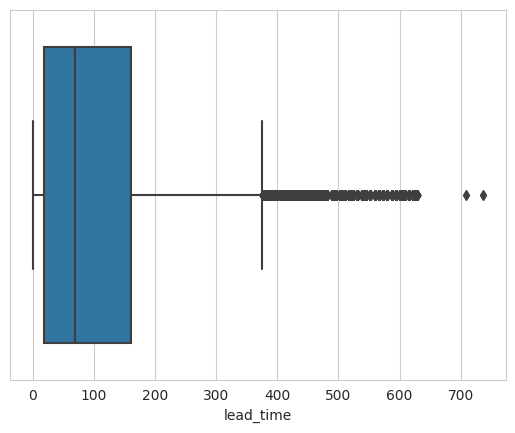

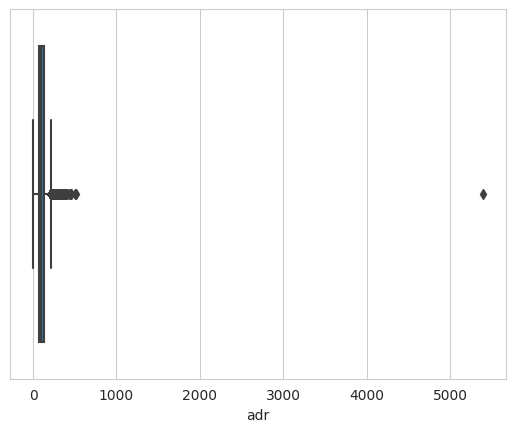

In [9]:
sns.boxplot(data=data, x = 'lead_time')
plt.show()

sns.boxplot(data=data, x = 'adr')
plt.show()

In [10]:
IQR_lt = data['lead_time'].quantile(0.75) -  data['lead_time'].quantile(0.25)
RUB = data['lead_time'].quantile(0.75) + 1.5*IQR_lt

data_no_outlier = data[data['lead_time'] <= RUB]

In [11]:
IQR_adr = data['adr'].quantile(0.75) -  data['adr'].quantile(0.25)
RUB = data['adr'].quantile(0.75) + 1.5*IQR_adr

data_no_outlier = data_no_outlier[data_no_outlier['adr'] <= RUB]

**From which countries do the guests originate?**

In [12]:
data_country = pd.DataFrame(data.loc[data['is_canceled'] != 1]['country'].value_counts())
data_country.index.name = 'country'
data_country.rename(columns={"country": "Number of Guests"}, inplace=True)
total_guests = data_country["Number of Guests"].sum()
data_country["Guests in %"] = round(data_country["Number of Guests"] / total_guests * 100, 2)
data_country.head(10)

,Number of Guests,Guests in %
country,,
PRT,20977,27.97
GBR,9668,12.89
FRA,8468,11.29
ESP,6383,8.51
DEU,6067,8.09
IRL,2542,3.39
ITA,2428,3.24
BEL,1868,2.49
NLD,1716,2.29


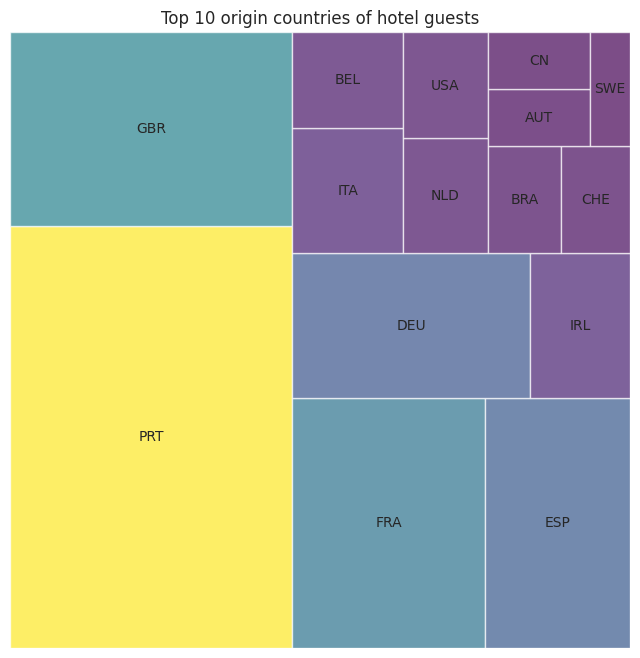

In [16]:
top_10_countries = data_country.head(15)

plt.figure(figsize=(8, 8))

colors = plt.cm.viridis((top_10_countries['Guests in %'] - top_10_countries['Guests in %'].min())
                        / (top_10_countries['Guests in %'].max() - top_10_countries['Guests in %'].min()))

squarify.plot(sizes=top_10_countries['Guests in %'], label=top_10_countries.index, color=colors, alpha=0.7)
plt.title('Top 10 origin countries of hotel guests')
plt.axis('off')
plt.show()

From the above data, the country Portugal dominates as the primary origin of guests in the hotel.

In [19]:
import plotly.express as px
guest_map = px.choropleth(data_country,
                    locations=data_country.index,
                    color=data_country["Guests in %"],
                    hover_name=data_country.index,
                    color_continuous_scale=px.colors.sequential.Viridis,
                    title="Origin countries of hotel guests")
guest_map.show()

Based on the data visualization above, the hotel has been visited by tourists from nearly all countries. The countries colored in white indicate that there haven't been any tourists from those countries visiting the hotel yet.
European countries frequently visit this hotel.

**Number of guests per month based on hotel each year**

In [35]:
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
guest_data = data[data['is_canceled'] == 0].copy()
guests_monthly = guest_data[['hotel', 'arrival_date_year', 'arrival_date_month', 'adults', 'children', 'babies']].sort_values('arrival_date_year')
guests_monthly['total visitors'] = guests_monthly['adults'] + guests_monthly['children'] + guests_monthly['babies']
guests_monthly = guests_monthly.astype({'total visitors' : int})
guests_monthly = guests_monthly.drop(['adults', 'children', 'babies'], axis=1)
guests_monthly.head()

,hotel,arrival_date_year,arrival_date_month,total visitors
0,Resort Hotel,2015,July,2
43256,City Hotel,2015,September,2
43257,City Hotel,2015,September,2
43258,City Hotel,2015,September,2
43259,City Hotel,2015,September,2


In [36]:
guests_monthly['arrival_date_month'] = pd.Categorical(guests_monthly['arrival_date_month'], categories=months, ordered=True)
guests_monthly = guests_monthly.groupby(['hotel', 'arrival_date_year', 'arrival_date_month'], as_index = False).sum()

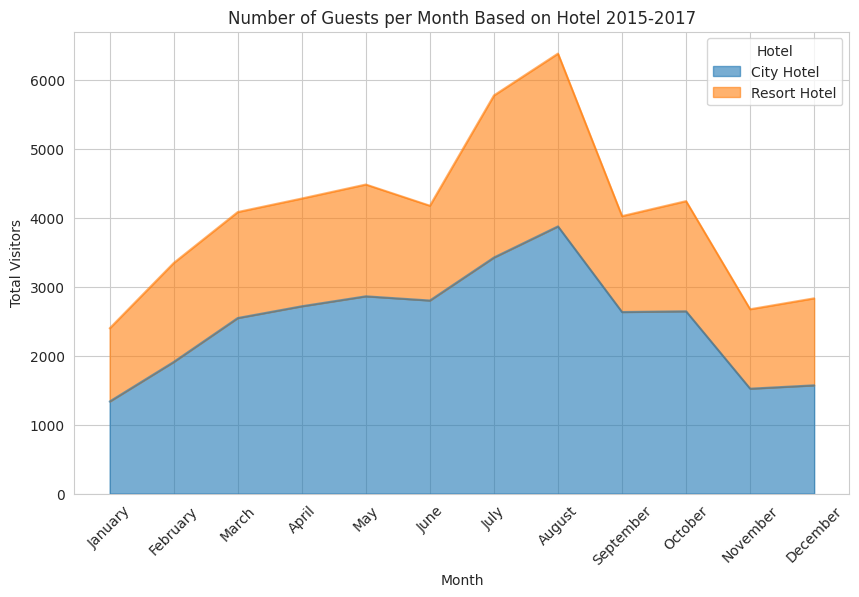

In [42]:
pivot_data = guests_monthly.pivot_table(values='total visitors', index=['arrival_date_month'], columns='hotel', fill_value=0)

ax = pivot_data.plot(kind='area', figsize=(10, 6), alpha=0.6)
plt.title('Number of Guests per Month Based on Hotel 2015-2017')
plt.xlabel('Month')
plt.ylabel('Total Visitors')
plt.legend(title='Hotel', bbox_to_anchor=(1, 1))
plt.xticks(range(len(pivot_data.index)), pivot_data.index, rotation=45)
plt.show()

**How many bookings were canceled**

In [43]:
total_cancelations = data['is_canceled'].sum()
rh_cancelations = data.loc[data["hotel"] == "Resort Hotel"]["is_canceled"].sum()
ch_cancelations = data.loc[data["hotel"] == "City Hotel"]["is_canceled"].sum()

rel_cancel = (total_cancelations / data.shape[0]) * 100
rh_rel_cancel = (rh_cancelations / data.loc[data["hotel"] == "Resort Hotel"].shape[0]) * 100
ch_rel_cancel = (ch_cancelations / data.loc[data["hotel"] == "City Hotel"].shape[0]) * 100

print(f"Total booking were canceled: {total_cancelations:} ({rel_cancel:.0f} %)")
print(f"Resort hotel bookings were canceled: {rh_cancelations:} ({rh_rel_cancel:.0f} %)")
print(f"City hotel bookings were canceled:: {ch_cancelations:} ({ch_rel_cancel:.0f} %)")

Total booking were canceled: 44199 (37 %)
Resort hotel bookings were canceled: 11120 (28 %)
City hotel bookings were canceled:: 33079 (42 %)


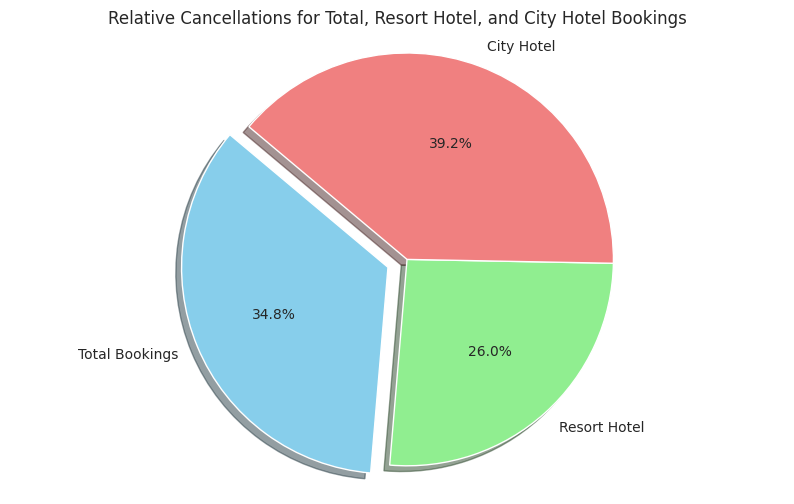

In [44]:
labels = ['Total Bookings', 'Resort Hotel', 'City Hotel']
sizes = [rel_cancel, rh_rel_cancel, ch_rel_cancel]
colors = ['skyblue', 'lightgreen', 'lightcoral']
explode = (0.1, 0, 0)

plt.figure(figsize=(10, 6))

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Relative Cancellations for Total, Resort Hotel, and City Hotel Bookings')
plt.axis('equal')
plt.show()

In [47]:
res_book_per_month = data.loc[(data["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["hotel"].count()
res_cancel_per_month = data.loc[(data["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

cty_book_per_month = data.loc[(data["hotel"] == "City Hotel")].groupby("arrival_date_month")["hotel"].count()
cty_cancel_per_month = data.loc[(data["hotel"] == "City Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

res_cancel_data = pd.DataFrame({"Hotel": "Resort Hotel",
                                "Month": list(res_book_per_month.index),
                                "Bookings": list(res_book_per_month.values),
                                "Cancelations": list(res_cancel_per_month.values)})

cty_cancel_data = pd.DataFrame({"Hotel": "City Hotel",
                                "Month": list(cty_book_per_month.index),
                                "Bookings": list(cty_book_per_month.values),
                                "Cancelations": list(cty_cancel_per_month.values)})

full_cancel_data = pd.concat([res_cancel_data, cty_cancel_data], ignore_index=True)
full_cancel_data["cancel_percent"] = full_cancel_data["Cancelations"] / full_cancel_data["Bookings"] * 100

ordered_months = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]
full_cancel_data["Month"] = pd.Categorical(full_cancel_data["Month"], categories=ordered_months, ordered=True)

In [51]:
full_cancel_data

,Hotel,Month,Bookings,Cancelations,cancel_percent
0,Resort Hotel,April,3609,1059,29.343308
1,Resort Hotel,August,4894,1637,33.449121
2,Resort Hotel,December,2645,631,23.856333
3,Resort Hotel,February,3102,794,25.596389
4,Resort Hotel,January,2191,325,14.833409
5,Resort Hotel,July,4573,1436,31.401706
6,Resort Hotel,June,3044,1007,33.081472
7,Resort Hotel,March,3334,763,22.885423
8,Resort Hotel,May,3559,1024,28.772127
9,Resort Hotel,November,2435,460,18.891170


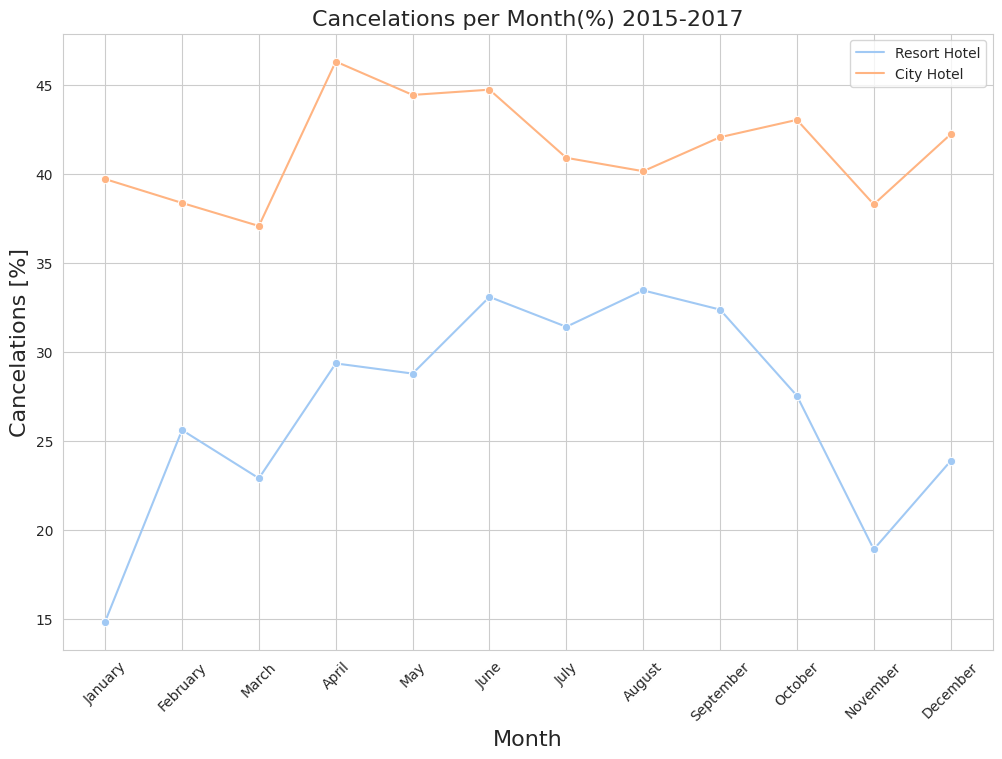

In [48]:
plt.figure(figsize=(12, 8))
sns.lineplot(x="Month", y="cancel_percent", hue="Hotel", data=full_cancel_data, marker="o", palette="pastel")
plt.title("Cancelations per Month(%) 2015-2017", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.legend(loc="upper right")
plt.show()

In [49]:
adult_only = data[(data['adults'] != 0) & (data['children'] == 0) & (data['babies'] == 0)].sort_values('reserved_room_type')
adult_child = data[(data['adults'] != 0) & (data['children'] != 0) | (data['babies'] != 0)].sort_values('reserved_room_type')

In [50]:
percentage = [(len(adult_only)/(len(adult_only) + len(adult_child)))*100, (len(adult_child)/(len(adult_only) + len(adult_child)))*100]
labels = ['Traveling without Children', 'Traveling with Children']

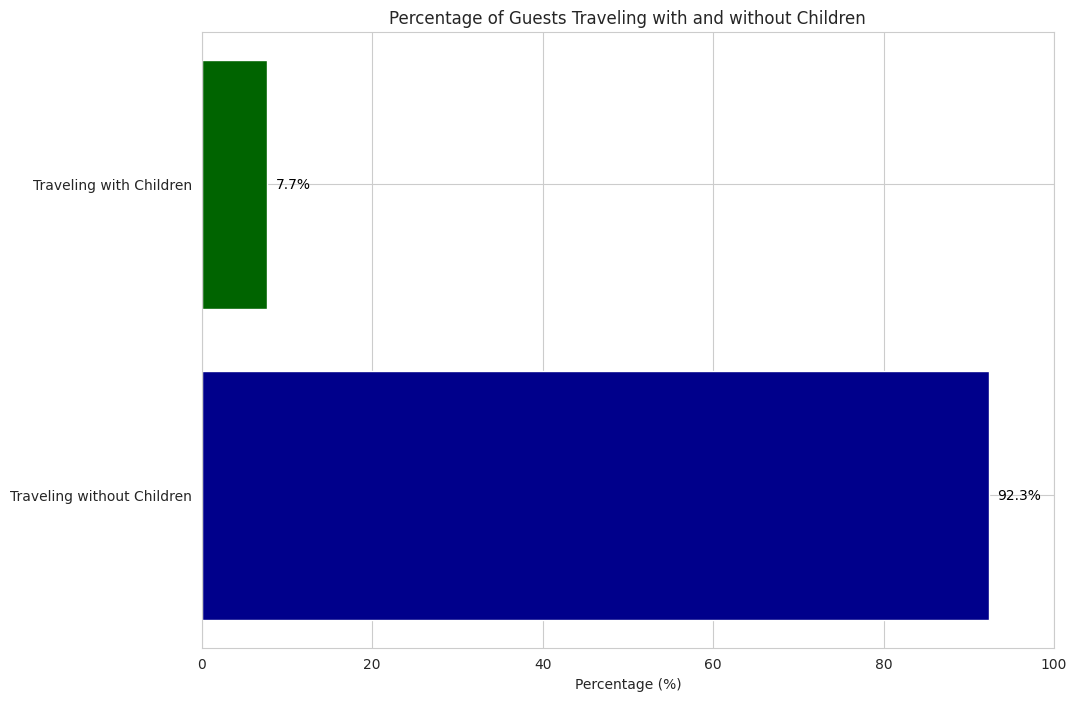

In [51]:
plt.figure(figsize=(11, 8))
plt.barh(labels, percentage, color=['darkblue', 'darkgreen'])
for index, value in enumerate(percentage):
    plt.text(value + 1, index, f'{value:.1f}%', color='black', va='center')
plt.title('Percentage of Guests Traveling with and without Children')
plt.xlabel('Percentage (%)')
plt.xlim(0, 100)
plt.show()